In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datmin2/dataset_preprocessed2.csv
/kaggle/input/datmin-final/dataset_preprocessed_final.csv


## Import

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import transformers
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CPU mode - training will be slower")

Using device: cuda
GPU: Tesla T4
VRAM: 14.74 GB


## Load Data

In [3]:
# Load preprocessed dataset
df = pd.read_csv('../input/datmin-final/dataset_preprocessed_final.csv')

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"First few texts:\n{df['text_clean'].head()}\n")

# Define emotion columns
emotion_cols = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 
                'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 
                'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 
                'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 
                'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 
                'neutral']

print(f"Number of emotion labels: {len(emotion_cols)}")
print(f"Emotions: {emotion_cols}\n")

# Get labels
X = df['text_clean'].values
y = df[emotion_cols].values

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Sample text: {X[0][:100]}...")
print(f"Sample labels: {y[0]}")
print(f"Emotions for first sample: {[emotion_cols[i] for i in range(len(emotion_cols)) if y[0][i] == 1]}")

Dataset Info:
Shape: (57561, 29)
First few texts:
0               omg person is so cute in this artstyle
1    my liver cries watching these kids. weeps into...
2    sadly, the military is archaic about non-confo...
3    everytime i wore white pants! finally got an a...
4                                   but person is fine
Name: text_clean, dtype: object

Number of emotion labels: 28
Emotions: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

Features shape: (57561,)
Labels shape: (57561, 28)
Sample text: omg person is so cute in this artstyle...
Sample labels: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Emotions for first sample: ['admiration']


## Tokenization

In [4]:
# Initialize BERT tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Using model: {model_name}")
print(f"Tokenizer vocabulary size: {len(tokenizer)}")

# Tokenize texts
def tokenize_texts(texts, max_length=256, batch_size=32):
    """Tokenize texts with BERT tokenizer"""
    input_ids = []
    attention_masks = []
    
    print(f"Tokenizing {len(texts)} texts...")
    for text in tqdm(texts):
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors=None
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    
    return np.array(input_ids), np.array(attention_masks)

# Tokenize all texts
input_ids, attention_masks = tokenize_texts(X, max_length=256)

print(f"\nInput IDs shape: {input_ids.shape}")
print(f"Attention masks shape: {attention_masks.shape}")
print(f"Sample input IDs (first 20 tokens): {input_ids[0][:20]}")
print(f"Sample attention mask (first 20 tokens): {attention_masks[0][:20]}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Using model: bert-base-uncased
Tokenizer vocabulary size: 30522
Tokenizing 57561 texts...


100%|██████████| 57561/57561 [00:09<00:00, 6298.06it/s]



Input IDs shape: (57561, 256)
Attention masks shape: (57561, 256)
Sample input IDs (first 20 tokens): [  101 18168  2290  2711  2003  2061 10140  1999  2023  2840 27983   102
     0     0     0     0     0     0     0     0]
Sample attention mask (first 20 tokens): [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


## DataLoaders

In [5]:
# Split data into train, validation, and test sets
X_train_ids, X_temp_ids, X_train_mask, X_temp_mask, y_train, y_temp = train_test_split(
    input_ids, attention_masks, y, test_size=0.2, random_state=42
)

X_val_ids, X_test_ids, X_val_mask, X_test_mask, y_val, y_test = train_test_split(
    X_temp_ids, X_temp_mask, y_temp, test_size=0.5, random_state=42
)

print(f"Train set size: {len(X_train_ids)}")
print(f"Validation set size: {len(X_val_ids)}")
print(f"Test set size: {len(X_test_ids)}")

# Convert to tensors
X_train_ids = torch.tensor(X_train_ids, dtype=torch.long)
X_train_mask = torch.tensor(X_train_mask, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val_ids = torch.tensor(X_val_ids, dtype=torch.long)
X_val_mask = torch.tensor(X_val_mask, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test_ids = torch.tensor(X_test_ids, dtype=torch.long)
X_test_mask = torch.tensor(X_test_mask, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
batch_size = 32

train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_ids, X_val_mask, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train set size: 46048
Validation set size: 5756
Test set size: 5757

DataLoaders created:
Train batches: 1439
Validation batches: 180
Test batches: 180


## Model Architecture

In [6]:
import torch.nn.functional as F

class STBERTBase(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.hidden = self.bert.config.hidden_size
        self.loss_fn = nn.BCELoss()

    def compute_loss(self, logits, labels):
        return self.loss_fn(logits, labels)

class STBERT_CON(STBERTBase):
    def __init__(self, model_name, num_labels, dropout_rate=0.3):
        super().__init__(model_name)
        H = self.hidden

        self.dropout = nn.Dropout(dropout_rate)

        # Conv1D: input channel = H, output channel = H
        self.conv = nn.Conv1d(H, H, kernel_size=3, padding=1)

        self.fc = nn.Linear(H, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, ids, mask):
        out = self.bert(ids, mask).last_hidden_state   # [B, S, H]

        # CNN expects [B, C, S]
        x = out.permute(0, 2, 1)  # [B, H, S]

        x = F.relu(self.conv(x))  # [B, H, S]
        x = torch.mean(x, dim=2)  # Global average pooling → [B, H]

        x = self.dropout(x)
        logits = self.sigmoid(self.fc(x))

        return logits


# Initialize model
num_labels = len(emotion_cols)
model = STBERT_CON(model_name, num_labels, dropout_rate=0.3)
model = model.to(device)

print(f"Model initialized:")
print(f"Number of labels: {num_labels}")
print(f"Model architecture:")
print(model)

2025-12-17 00:36:40.976465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765931801.158828      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765931801.212259      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model initialized:
Number of labels: 28
Model architecture:
STBERT_CON(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
          

## Training Functions

In [7]:
def train_epoch(model, train_loader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(tqdm(train_loader)):
        # Move to device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = model.compute_loss(logits, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device, threshold=0.5):
    """Validate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for input_ids, attention_mask, labels in tqdm(val_loader):
            # Move to device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = model.compute_loss(logits, labels)
            
            total_loss += loss.item()
            
            # Store predictions and labels
            preds = (logits > threshold).cpu().numpy()
            labels_np = labels.cpu().numpy()
            
            all_preds.append(preds)
            all_labels.append(labels_np)
    
    avg_loss = total_loss / len(val_loader)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate metrics
    hamming = hamming_loss(all_labels, all_preds)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return avg_loss, hamming, f1_micro, f1_macro, all_preds, all_labels

print("Training functions defined!")

Training functions defined!


## Train Model

In [8]:
# Training configuration
num_epochs = 3  # Reduced from 5 to 3 epochs
learning_rate = 2e-5
weight_decay = 0.01

# Use smaller batch size for faster iterations (but may need more memory)
batch_size_training = 16  # Reduced from 32

# Recreate train loader with smaller batch size
train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size_training, shuffle=True)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1),
    num_training_steps=total_steps
)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_hamming': [],
    'val_f1_micro': [],
    'val_f1_macro': []
}

best_val_f1 = 0
patience = 2  # Reduced from 3 to 2 (stop earlier if no improvement)
patience_counter = 0

# Training loop
print(f"Starting training (optimized: 3 epochs, batch_size={batch_size_training})...\n")
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    history['train_loss'].append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    # Validate
    val_loss, hamming, f1_micro, f1_macro, _, _ = validate(model, val_loader, device)
    history['val_loss'].append(val_loss)
    history['val_hamming'].append(hamming)
    history['val_f1_micro'].append(f1_micro)
    history['val_f1_macro'].append(f1_macro)
    
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    
    # Early stopping
    if f1_macro > best_val_f1:
        best_val_f1 = f1_macro
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), '/kaggle/working/best_emotion_classifier.pt')
        print("✓ Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break
    
    print()

print("Training completed!")

# Load best model
model.load_state_dict(torch.load('/kaggle/working/best_emotion_classifier.pt'))
print("Best model loaded!")

Starting training (optimized: 3 epochs, batch_size=16)...

Epoch 1/3
--------------------------------------------------


100%|██████████| 2878/2878 [38:46<00:00,  1.24it/s]


Train Loss: 0.1737


100%|██████████| 180/180 [01:36<00:00,  1.86it/s]


Val Loss: 0.1223
Hamming Loss: 0.0395
F1 Score (Micro): 0.3216
F1 Score (Macro): 0.2149
✓ Model saved!

Epoch 2/3
--------------------------------------------------


100%|██████████| 2878/2878 [38:55<00:00,  1.23it/s]


Train Loss: 0.1202


100%|██████████| 180/180 [01:37<00:00,  1.85it/s]


Val Loss: 0.1190
Hamming Loss: 0.0394
F1 Score (Micro): 0.3600
F1 Score (Macro): 0.2610
✓ Model saved!

Epoch 3/3
--------------------------------------------------


100%|██████████| 2878/2878 [38:58<00:00,  1.23it/s]


Train Loss: 0.1100


100%|██████████| 180/180 [01:36<00:00,  1.86it/s]


Val Loss: 0.1196
Hamming Loss: 0.0395
F1 Score (Micro): 0.3795
F1 Score (Macro): 0.2910
✓ Model saved!

Training completed!
Best model loaded!


## Plot History

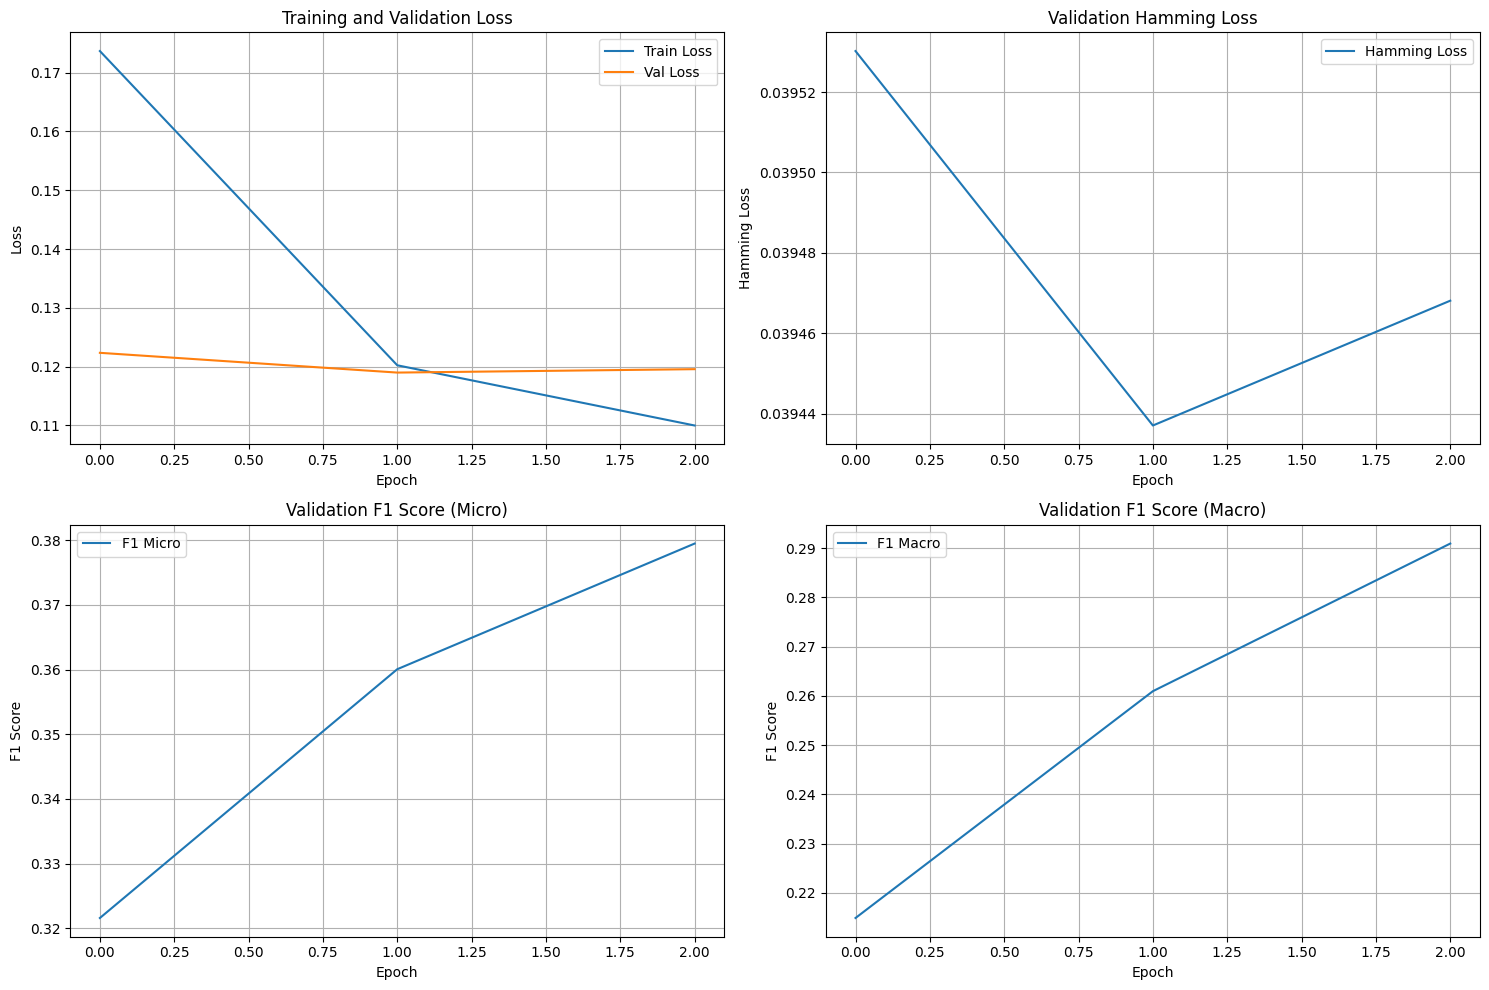

Training history plot saved as 'training_history.png'


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss')
axes[0, 0].plot(history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Hamming Loss
axes[0, 1].plot(history['val_hamming'], label='Hamming Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Hamming Loss')
axes[0, 1].set_title('Validation Hamming Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# F1 Micro
axes[1, 0].plot(history['val_f1_micro'], label='F1 Micro')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Validation F1 Score (Micro)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# F1 Macro
axes[1, 1].plot(history['val_f1_macro'], label='F1 Macro')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Validation F1 Score (Macro)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved as 'training_history.png'")

## Test Evaluation

In [10]:
print("Evaluating on test set...\n")
test_loss, test_hamming, test_f1_micro, test_f1_macro, test_preds, test_labels = validate(model, test_loader, device)

print("=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Hamming Loss: {test_hamming:.4f}")
print(f"F1 Score (Micro): {test_f1_micro:.4f}")
print(f"F1 Score (Macro): {test_f1_macro:.4f}")
print()

# Per-emotion metrics
print("Per-Emotion F1 Scores:")
print("-" * 60)
report = classification_report(test_labels, test_preds, target_names=emotion_cols, zero_division=0)
print(report)

Evaluating on test set...



100%|██████████| 180/180 [01:37<00:00,  1.85it/s]

TEST SET EVALUATION
Test Loss: 0.1224
Hamming Loss: 0.0405
F1 Score (Micro): 0.3657
F1 Score (Macro): 0.2849

Per-Emotion F1 Scores:
------------------------------------------------------------
                precision    recall  f1-score   support

    admiration       0.63      0.53      0.57       579
     amusement       0.63      0.62      0.62       322
         anger       0.51      0.29      0.37       241
     annoyance       0.45      0.03      0.06       431
      approval       0.48      0.14      0.21       594
        caring       0.42      0.19      0.27       196
     confusion       0.43      0.13      0.20       231
     curiosity       0.54      0.36      0.43       323
        desire       0.52      0.23      0.32       128
disappointment       0.32      0.05      0.09       251
   disapproval       0.53      0.18      0.27       421
       disgust       0.59      0.14      0.23       167
 embarrassment       0.53      0.14      0.22        71
    excitement       

## Inference

In [11]:
def predict_emotions(text, model, tokenizer, device, emotion_cols, threshold=0.5):
    """
    Predict emotions for a given text
    """
    model.eval()
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    
    # Get probabilities
    probs = logits.cpu().numpy()[0]
    
    # Get predicted emotions
    predicted_emotions = []
    emotion_probs = {}
    
    for emotion, prob in zip(emotion_cols, probs):
        emotion_probs[emotion] = float(prob)
        if prob > threshold:
            predicted_emotions.append((emotion, prob))
    
    # Sort by probability
    predicted_emotions.sort(key=lambda x: x[1], reverse=True)
    
    return predicted_emotions, emotion_probs

# Test with sample texts
print("=" * 80)
print("EMOTION PREDICTION ON SAMPLE TEXTS")
print("=" * 80)

sample_texts = [
    "I'm so happy and excited about this amazing news!",
    "This is absolutely terrible and I hate it.",
    "I don't understand what's happening here.",
    "Thank you so much for your help and support!",
    "I'm really worried and anxious about the situation."
]

for i, text in enumerate(sample_texts, 1):
    print(f"\n{i}. Text: {text}")
    predicted, probs = predict_emotions(text, model, tokenizer, device, emotion_cols, threshold=0.5)
    
    print(f"   Predicted emotions (threshold=0.5):")
    if predicted:
        for emotion, prob in predicted:
            print(f"   - {emotion:15s}: {prob:.4f}")
    else:
        print(f"   - No emotions detected with threshold=0.5")
    
    print(f"\n   Top 5 emotions by probability:")
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:5]
    for emotion, prob in sorted_probs:
        print(f"   - {emotion:15s}: {prob:.4f}")

EMOTION PREDICTION ON SAMPLE TEXTS

1. Text: I'm so happy and excited about this amazing news!
   Predicted emotions (threshold=0.5):
   - excitement     : 0.8037
   - joy            : 0.5126

   Top 5 emotions by probability:
   - excitement     : 0.8037
   - joy            : 0.5126
   - admiration     : 0.0947
   - gratitude      : 0.0464
   - surprise       : 0.0433

2. Text: This is absolutely terrible and I hate it.
   Predicted emotions (threshold=0.5):
   - No emotions detected with threshold=0.5

   Top 5 emotions by probability:
   - anger          : 0.4165
   - disgust        : 0.3498
   - fear           : 0.1324
   - annoyance      : 0.0923
   - disapproval    : 0.0821

3. Text: I don't understand what's happening here.
   Predicted emotions (threshold=0.5):
   - confusion      : 0.8190

   Top 5 emotions by probability:
   - confusion      : 0.8190
   - disapproval    : 0.0835
   - curiosity      : 0.0785
   - annoyance      : 0.0375
   - neutral        : 0.0339

4. Text: T

## Performance Analysis


Per-Emotion Performance Summary:
                precision    recall        f1  support
gratitude        0.894904  0.747340  0.814493    376.0
love             0.647510  0.625926  0.636535    270.0
amusement        0.629747  0.618012  0.623824    322.0
admiration       0.626531  0.530225  0.574369    579.0
fear             0.578313  0.436364  0.497409    110.0
curiosity        0.537383  0.356037  0.428305    323.0
surprise         0.588889  0.281915  0.381295    188.0
anger            0.507143  0.294606  0.372703    241.0
optimism         0.562044  0.270175  0.364929    285.0
sadness          0.521368  0.269912  0.355685    226.0
remorse          0.594595  0.226804  0.328358     97.0
desire           0.517857  0.226562  0.315217    128.0
joy              0.593023  0.186813  0.284123    273.0
disapproval      0.528169  0.178147  0.266430    421.0
caring           0.422222  0.193878  0.265734    196.0
disgust          0.585366  0.143713  0.230769    167.0
embarrassment    0.526316  0.14

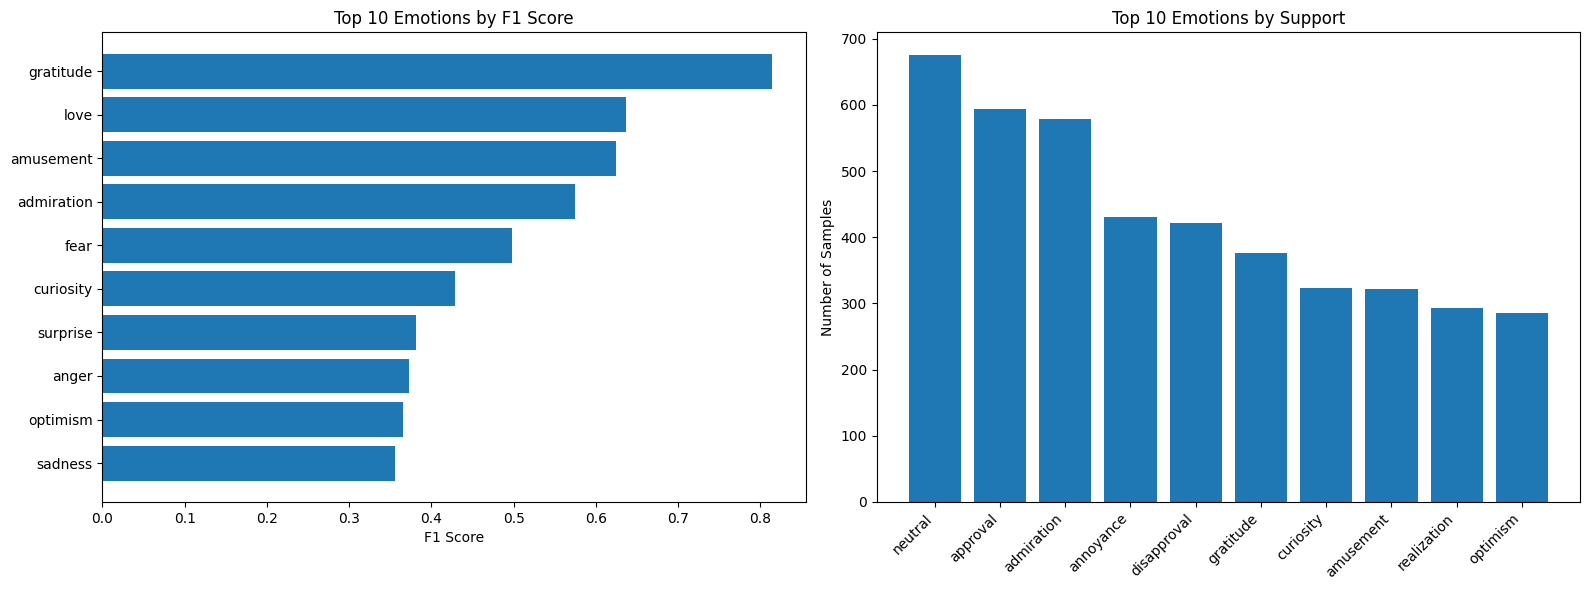


Emotion performance plot saved as 'emotion_performance.png'


In [12]:
# Calculate metrics for each emotion
emotion_metrics = {}
for i, emotion in enumerate(emotion_cols):
    cm = confusion_matrix(test_labels[:, i], test_preds[:, i], labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    emotion_metrics[emotion] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': (tp + fn)
    }

# Create summary dataframe
metrics_df = pd.DataFrame(emotion_metrics).T
metrics_df = metrics_df.sort_values('f1', ascending=False)

print("\nPer-Emotion Performance Summary:")
print(metrics_df.to_string())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top emotions by F1 score
top_emotions = metrics_df.head(10)
axes[0].barh(range(len(top_emotions)), top_emotions['f1'])
axes[0].set_yticks(range(len(top_emotions)))
axes[0].set_yticklabels(top_emotions.index)
axes[0].set_xlabel('F1 Score')
axes[0].set_title('Top 10 Emotions by F1 Score')
axes[0].invert_yaxis()

# Emotion support distribution
emotion_support = metrics_df['support'].astype(int).sort_values(ascending=False).head(10)
axes[1].bar(range(len(emotion_support)), emotion_support.values)
axes[1].set_xticks(range(len(emotion_support)))
axes[1].set_xticklabels(emotion_support.index, rotation=45, ha='right')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Top 10 Emotions by Support')

plt.tight_layout()
plt.savefig('/kaggle/working/emotion_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEmotion performance plot saved as 'emotion_performance.png'")

## Confusion Matrix

Creating confusion matrices for all emotions...



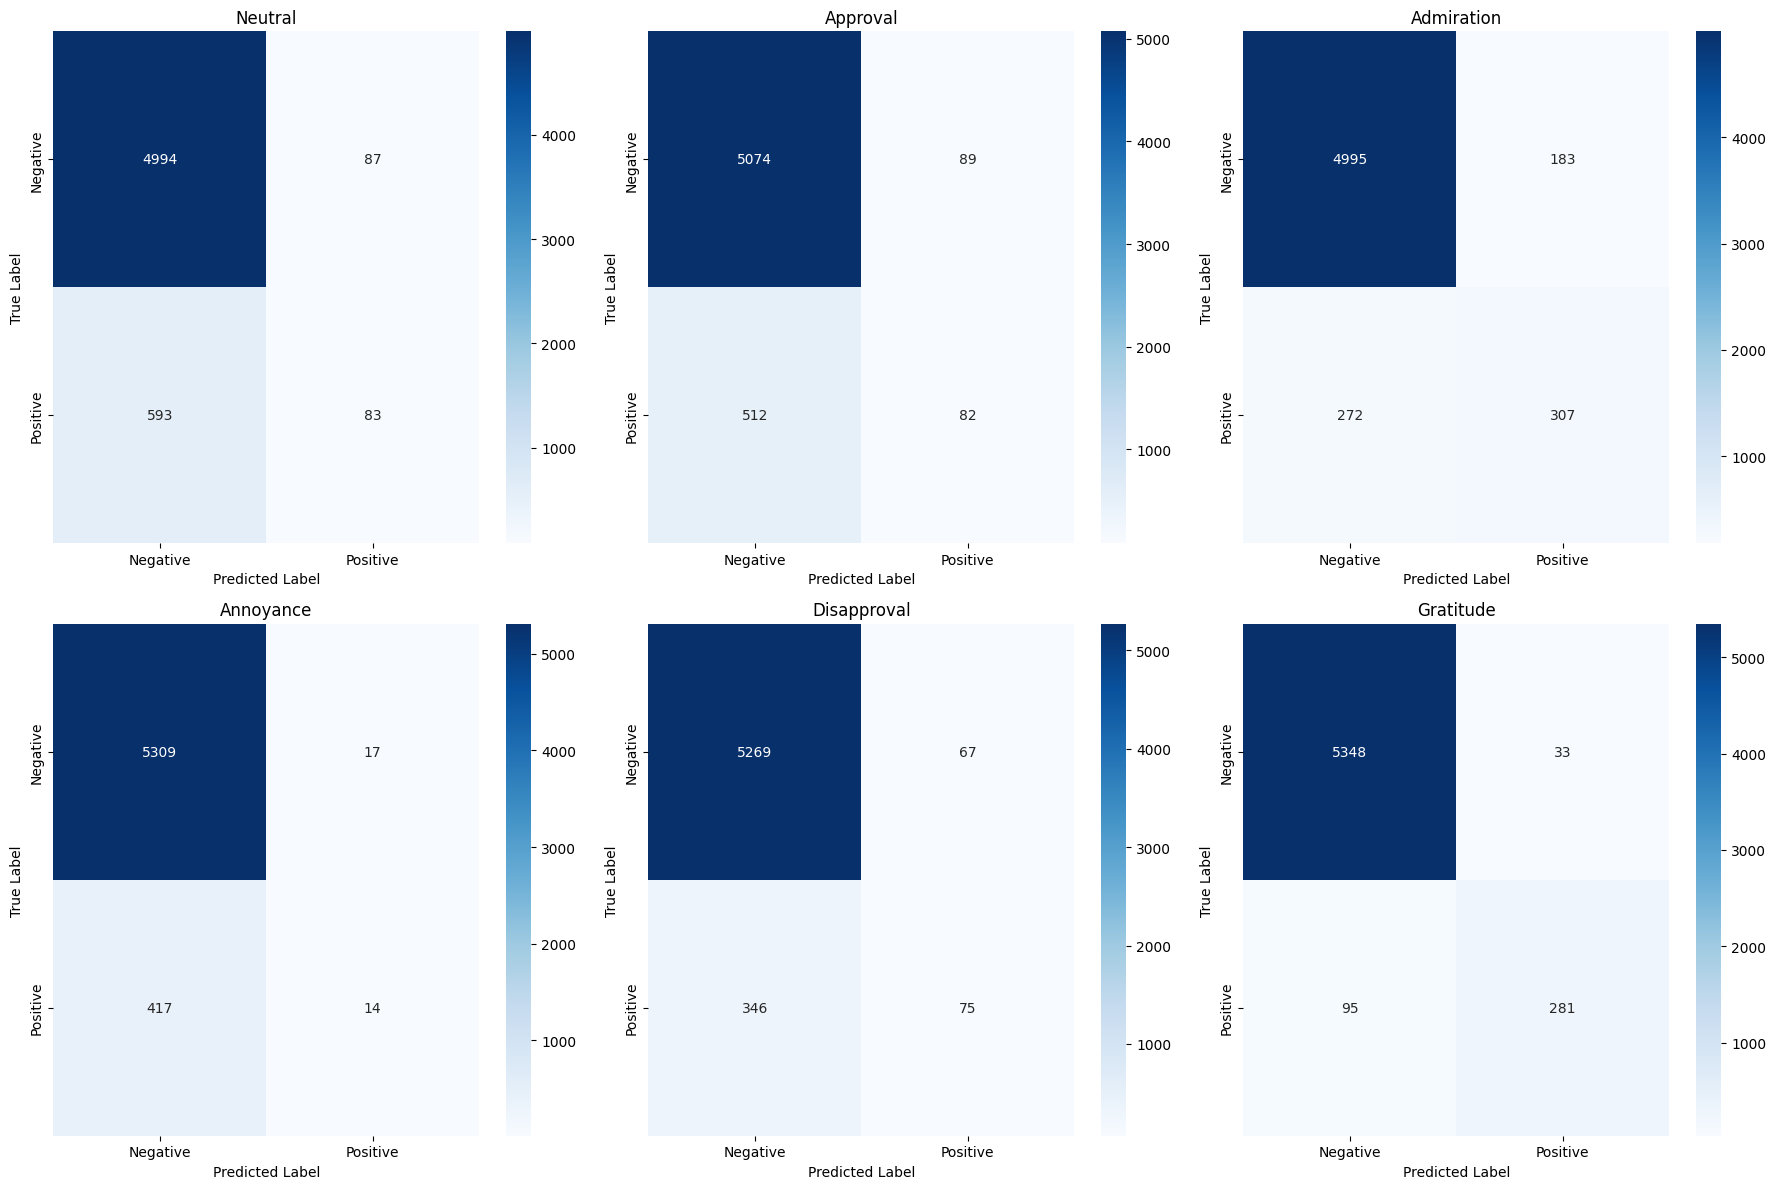

Confusion matrices for top 6 emotions saved as 'confusion_matrices_top6.png'

AGGREGATE CONFUSION MATRIX (All Emotions Combined)


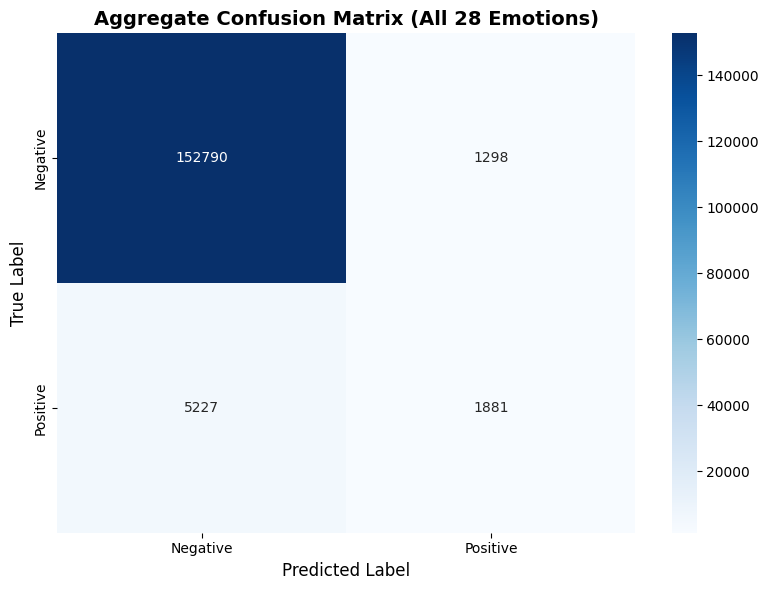


Aggregate confusion matrix saved as 'confusion_matrix_aggregate.png'

Aggregate Confusion Matrix Values:
  True Negatives:  152,790
  False Positives: 1,298
  False Negatives: 5,227
  True Positives:  1,881

Aggregate Metrics:
  Accuracy:  0.9595
  Precision: 0.5917
  Recall:    0.2646
  F1 Score:  0.3657


In [13]:
# Calculate confusion matrix for each emotion
print("Creating confusion matrices for all emotions...\n")

# Create a figure with subplots for top 6 emotions by F1 score
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Get top 6 emotions by support
top_emotions_list = metrics_df.nlargest(6, 'support').index.tolist()

for idx, emotion in enumerate(top_emotions_list):
    emotion_idx = emotion_cols.index(emotion)
    cm = confusion_matrix(test_labels[:, emotion_idx], test_preds[:, emotion_idx])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[idx].set_title(f'{emotion.capitalize()}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices_top6.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrices for top 6 emotions saved as 'confusion_matrices_top6.png'")

# Create aggregate confusion matrix (sum of all emotions)
print("\n" + "=" * 60)
print("AGGREGATE CONFUSION MATRIX (All Emotions Combined)")
print("=" * 60)

aggregate_cm = np.zeros((2, 2), dtype=int)
for i in range(len(emotion_cols)):
    cm = confusion_matrix(test_labels[:, i], test_preds[:, i])
    aggregate_cm += cm

# Plot aggregate confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(aggregate_cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
ax.set_title('Aggregate Confusion Matrix (All 28 Emotions)', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix_aggregate.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAggregate confusion matrix saved as 'confusion_matrix_aggregate.png'")

# Print aggregate metrics
tn, fp, fn, tp = aggregate_cm.ravel()
print(f"\nAggregate Confusion Matrix Values:")
print(f"  True Negatives:  {tn:,}")
print(f"  False Positives: {fp:,}")
print(f"  False Negatives: {fn:,}")
print(f"  True Positives:  {tp:,}")
print(f"\nAggregate Metrics:")
print(f"  Accuracy:  {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"  Precision: {tp / (tp + fp) if (tp + fp) > 0 else 0:.4f}")
print(f"  Recall:    {tp / (tp + fn) if (tp + fn) > 0 else 0:.4f}")
print(f"  F1 Score:  {2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0:.4f}")

## Save Model

In [14]:
# Save the fine-tuned model
print("Saving model...")
torch.save(model.state_dict(), '/kaggle/working/emotion_classifier_finetuned.pt')

# Save model configuration
config = {
    'model_name': model_name,
    'num_labels': num_labels,
    'emotion_cols': emotion_cols,
    'max_length': 256,
    'dropout_rate': 0.3
}

with open('/kaggle/working/model_config.json', 'w') as f:
    json.dump(config, f, indent=4)

# Save metrics
metrics_summary = {
    'test_loss': float(test_loss),
    'test_hamming_loss': float(test_hamming),
    'test_f1_micro': float(test_f1_micro),
    'test_f1_macro': float(test_f1_macro),
    'training_config': {
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'weight_decay': weight_decay
    }
}

with open('/kaggle/working/model_metrics.json', 'w') as f:
    json.dump(metrics_summary, f, indent=4)

print("✓ Model saved as 'emotion_classifier_finetuned.pt'")
print("✓ Configuration saved as 'model_config.json'")
print("✓ Metrics saved as 'model_metrics.json'")

Saving model...
✓ Model saved as 'emotion_classifier_finetuned.pt'
✓ Configuration saved as 'model_config.json'
✓ Metrics saved as 'model_metrics.json'


## Summary

In [15]:
print("\n" + "=" * 80)
print("EMOTION CLASSIFICATION MODEL - FINAL SUMMARY")
print("=" * 80)

print("\n📊 DATASET INFORMATION:")
print(f"  • Total samples: {len(df):,}")
print(f"  • Number of emotions: {len(emotion_cols)}")
print(f"  • Train/Val/Test split: {len(X_train_ids)}/{len(X_val_ids)}/{len(X_test_ids)}")
print(f"  • Multi-label: Yes (average {y.sum(axis=1).mean():.2f} emotions per text)")

print("\n🤖 MODEL INFORMATION:")
print(f"  • Architecture: BERT Fine-Tuning (transformer-based)")
print(f"  • Base model: {model_name}")
print(f"  • Max sequence length: 256 tokens")
print(f"  • Classification layers: 768 → 256 → {num_labels} (BCELoss)")

print("\n⚙️ TRAINING CONFIGURATION:")
print(f"  • Epochs: {num_epochs}")
print(f"  • Batch size: {batch_size}")
print(f"  • Learning rate: {learning_rate}")
print(f"  • Optimizer: AdamW with linear warmup scheduler")
print(f"  • Early stopping: Yes (patience={patience})")

print("\n📈 TEST SET PERFORMANCE:")
print(f"  • Loss: {test_loss:.4f}")
print(f"  • Hamming Loss: {test_hamming:.4f}")
print(f"  • F1 Score (Micro): {test_f1_micro:.4f}")
print(f"  • F1 Score (Macro): {test_f1_macro:.4f}")

print("\n🎯 TOP 5 BEST PERFORMING EMOTIONS:")
for i, (emotion, metrics) in enumerate(metrics_df.head(5).iterrows(), 1):
    print(f"  {i}. {emotion:15s} - F1: {metrics['f1']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}")

print("\n💾 SAVED FILES:")
print(f"  • best_emotion_classifier.pt - Best model checkpoint")
print(f"  • emotion_classifier_finetuned.pt - Final fine-tuned model")
print(f"  • model_config.json - Model configuration")
print(f"  • model_metrics.json - Test metrics")
print(f"  • training_history.png - Training history plots")
print(f"  • emotion_performance.png - Emotion performance analysis")

print("\n" + "=" * 80)


EMOTION CLASSIFICATION MODEL - FINAL SUMMARY

📊 DATASET INFORMATION:
  • Total samples: 57,561
  • Number of emotions: 28
  • Train/Val/Test split: 46048/5756/5757
  • Multi-label: Yes (average 1.24 emotions per text)

🤖 MODEL INFORMATION:
  • Architecture: BERT Fine-Tuning (transformer-based)
  • Base model: bert-base-uncased
  • Max sequence length: 256 tokens
  • Classification layers: 768 → 256 → 28 (BCELoss)

⚙️ TRAINING CONFIGURATION:
  • Epochs: 3
  • Batch size: 32
  • Learning rate: 2e-05
  • Optimizer: AdamW with linear warmup scheduler
  • Early stopping: Yes (patience=2)

📈 TEST SET PERFORMANCE:
  • Loss: 0.1224
  • Hamming Loss: 0.0405
  • F1 Score (Micro): 0.3657
  • F1 Score (Macro): 0.2849

🎯 TOP 5 BEST PERFORMING EMOTIONS:
  1. gratitude       - F1: 0.8145, Precision: 0.8949, Recall: 0.7473
  2. love            - F1: 0.6365, Precision: 0.6475, Recall: 0.6259
  3. amusement       - F1: 0.6238, Precision: 0.6297, Recall: 0.6180
  4. admiration      - F1: 0.5744, Precisi